In [1]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
import torch
import pandas as pd
import torchmetrics

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, RecurrentNetwork
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

In [3]:
data = pd.read_csv("../data/raw/nodes.csv")
data

,timestamp,adservice_cpu,adservice_ram,cartservice_cpu,cartservice_ram,checkoutservice_cpu,checkoutservice_ram,currencyservice_cpu,currencyservice_ram,emailservice_cpu,...,paymentservice_cpu,paymentservice_ram,productcatalogservice_cpu,productcatalogservice_ram,recommendationservice_cpu,recommendationservice_ram,redis_cpu,redis_ram,shippingservice_cpu,shippingservice_ram
0,1701825744,0.006491,4.344186e+06,0.010313,2.792473e+03,0.005188,1.356858e+06,0.057166,4.505918e+06,0.004008,...,0.004668,2.030300e+06,0.021772,2.934991e+06,0.011848,5.497300e+06,0.004059,1.177182e+06,0.004627,1.403310e+03
1,1701825804,0.006662,1.122781e+03,0.006516,2.317005e+06,0.004203,1.181493e+02,0.047199,2.284438e+04,0.004733,...,0.003759,1.683843e+06,0.011461,1.618227e+06,0.011138,1.967024e+06,0.002752,1.420288e+06,0.003311,1.532223e+06
2,1701825864,0.005444,2.501221e+02,0.009085,1.911022e+06,0.003002,1.428579e+06,0.036961,1.115212e+04,0.004050,...,0.001572,4.198400e+03,0.017683,1.491514e+06,0.010565,1.563657e+02,0.003950,5.277394e+03,0.003696,1.363703e+06
3,1701825924,0.005505,0.000000e+00,0.009100,4.154800e+06,0.003821,1.409514e+06,0.053485,1.610893e+06,0.004510,...,0.004368,1.421130e+06,0.019390,1.280892e+06,0.009156,2.200314e+06,0.004141,1.435541e+06,0.003736,1.881729e+06
4,1701825984,0.002363,6.353886e+06,0.009596,4.152257e+06,0.003748,2.002629e+06,0.055062,1.341332e+04,0.004216,...,0.003510,1.601227e+06,0.018888,9.876798e+03,0.011243,4.731383e+06,0.003892,2.240093e+06,0.003977,3.218463e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1701911904,0.005540,2.687047e+02,0.010791,2.166942e+06,0.003826,3.199345e+06,0.059259,1.982433e+06,0.004989,...,0.003935,1.157220e+04,0.015134,2.147919e+06,0.010035,4.496351e+06,0.004098,1.795620e+06,0.004481,2.855173e+06
1436,1701911964,0.005088,3.671032e+06,0.010087,2.199581e+06,0.004691,1.446002e+06,0.052142,5.324126e+06,0.004859,...,0.004306,1.243972e+04,0.021002,1.375474e+06,0.012102,2.249621e+06,0.004079,1.284862e+06,0.004163,1.875621e+03
1437,1701912024,0.005208,3.785331e+06,0.009313,2.565518e+06,0.005312,2.847608e+03,0.055225,3.495819e+06,0.004952,...,0.003260,9.878573e+03,0.020117,1.535452e+06,0.012409,2.310013e+02,0.004184,2.399579e+06,0.003959,1.735775e+06
1438,1701912084,0.005101,3.770873e+06,0.007017,2.753052e+06,0.004301,5.264105e+02,0.036146,2.464451e+06,0.004621,...,0.004107,2.673667e+06,0.021580,4.005902e+06,0.012145,3.999036e+06,0.004027,5.680150e+03,0.003755,2.456472e+03


In [4]:
data["group"] = 0
data["time_idx"] = data["timestamp"].argsort()
data.describe()

,timestamp,adservice_cpu,adservice_ram,cartservice_cpu,cartservice_ram,checkoutservice_cpu,checkoutservice_ram,currencyservice_cpu,currencyservice_ram,emailservice_cpu,...,productcatalogservice_cpu,productcatalogservice_ram,recommendationservice_cpu,recommendationservice_ram,redis_cpu,redis_ram,shippingservice_cpu,shippingservice_ram,group,time_idx
count,1.440000e+03,1440.000000,1.440000e+03,1440.000000,1.440000e+03,1440.000000,1.440000e+03,1440.000000,1.440000e+03,1440.000000,...,1440.000000,1.440000e+03,1440.000000,1.440000e+03,1440.000000,1.440000e+03,1440.000000,1.440000e+03,1440.0,1440.000000
mean,1.701869e+09,0.005023,2.839818e+06,0.009493,2.539790e+06,0.004245,1.520532e+06,0.053026,2.147623e+06,0.004575,...,0.019514,1.957105e+06,0.011152,2.143491e+06,0.003962,1.220154e+06,0.004045,1.408181e+06,0.0,719.500000
std,2.496812e+04,0.000868,2.369915e+06,0.001301,1.697441e+06,0.000908,1.333184e+06,0.006749,1.415164e+06,0.000558,...,0.002438,1.137286e+06,0.001243,1.599418e+06,0.000441,8.704687e+05,0.000555,1.140044e+06,0.0,415.836506
min,1.701826e+09,0.002105,0.000000e+00,0.003849,0.000000e+00,0.001294,0.000000e+00,0.021259,0.000000e+00,0.001862,...,0.008112,0.000000e+00,0.005055,0.000000e+00,0.001684,0.000000e+00,0.001517,0.000000e+00,0.0,0.000000
25%,1.701847e+09,0.004860,2.403828e+02,0.009000,1.834103e+06,0.003631,3.690373e+03,0.050514,1.687784e+06,0.004495,...,0.018366,1.436528e+06,0.010704,6.673095e+03,0.003915,1.488095e+04,0.003820,6.205573e+03,0.0,359.750000
50%,1.701869e+09,0.005114,3.325431e+06,0.009699,2.295489e+06,0.004212,1.620129e+06,0.054169,2.053376e+06,0.004706,...,0.019870,1.767855e+06,0.011413,2.271910e+06,0.004055,1.253053e+06,0.004141,1.475048e+06,0.0,719.500000
75%,1.701891e+09,0.005308,4.121142e+06,0.010302,3.854424e+06,0.004848,2.280925e+06,0.057393,3.191778e+06,0.004882,...,0.021157,2.816662e+06,0.011970,2.855917e+06,0.004184,1.650502e+06,0.004388,2.004900e+06,0.0,1079.250000
max,1.701912e+09,0.022239,9.073732e+06,0.013248,7.943712e+06,0.008076,5.503465e+06,0.068982,7.097003e+06,0.007155,...,0.026502,5.516000e+06,0.017012,7.073663e+06,0.006030,4.172296e+06,0.007419,5.309284e+06,0.0,1439.000000


In [5]:
cutting_point = int(len(data) * 0.8)
max_encoder_length = 24
targets = list(data.columns.values)
targets.remove("timestamp")
targets.remove("group")
targets.remove("time_idx")

training = TimeSeriesDataSet(
    data.iloc[:cutting_point],
    time_idx="time_idx",
    target=targets,
    group_ids=["group"],
    max_encoder_length=60,
    min_prediction_length=1,
    max_prediction_length=6,
    static_reals=["group"],
    time_varying_known_reals=["timestamp", "time_idx"],
    time_varying_unknown_reals=targets,
    target_normalizer=MultiNormalizer(
        [EncoderNormalizer(
            method='standard',
            center=True,
            max_length=None,
            transformation=None,
            method_kwargs={})
        ] * len(targets)
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

## Baseline model

In [6]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
# MAE()(baseline_predictions.output, baseline_predictions.y)

2024-01-04 21:42:37.575943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 21:42:37.576127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 21:42:37.956404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 21:42:38.686648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 21:42:43.168184: W tensorflow/compiler/tf2

In [10]:
mae = torchmetrics.regression.MeanAbsoluteError().to("cuda")
mape = torchmetrics.regression.MeanAbsolutePercentageError().to("cuda")
mse = torchmetrics.regression.MeanSquaredError().to("cuda")

In [12]:
baseline_mae = mae(torch.cat(baseline_predictions.output), torch.cat(baseline_predictions.y[0]))
baseline_mape = mape(torch.cat(baseline_predictions.output), torch.cat(baseline_predictions.y[0]))
baseline_mse = mse(torch.cat(baseline_predictions.output), torch.cat(baseline_predictions.y[0]))

## Temporal Fusion Transformer

In [8]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cuda",
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="Ranger"
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 35.4k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.2454708915685031
Restoring states from the checkpoint path at /home/jlcg/projects/pod-resource-prediction/notebooks/.lr_find_3f98b2d1-ec6e-4712-9ffb-6b104edf998a.ckpt
Restored all states from the checkpoint at /home/jlcg/projects/pod-resource-prediction/notebooks/.lr_find_3f98b2d1-ec6e-4712-9ffb-6b104edf998a.ckpt


suggested learning rate: 0.2454708915685031


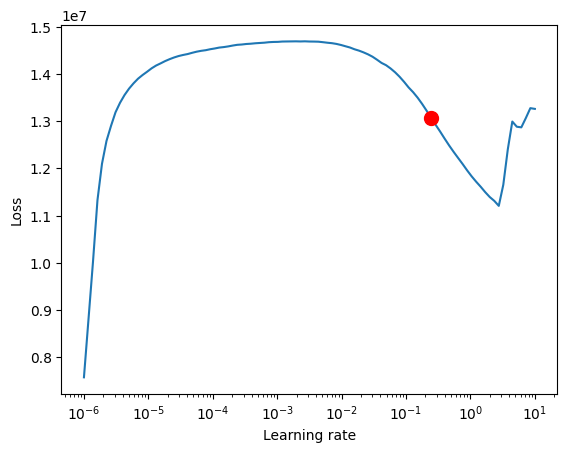

In [9]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [10]:
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [11]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 68.4k


In [12]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 32.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 17.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [62]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
torch.save(best_tft.state_dict(), "../models/transformer.pt")

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [19]:
best_tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
best_tft.load_state_dict(torch.load("../models/transformer.pt"))
best_tft.to("cuda")

TemporalFusionTransformer(
  	"attention_head_size":               2
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            8
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       16
  	"learning_rate":                     0.2
  	"log_gradient_flow":                 False
  	"log_interval":                      10
  	"log_val_interval":                  10
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              MultiLoss(QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98

In [20]:
tft_predictions = best_tft.predict(val_dataloader, return_y=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [21]:
tft_mae = mae(torch.cat(tft_predictions.output), torch.cat(tft_predictions.y[0]))
tft_mape = mape(torch.cat(tft_predictions.output), torch.cat(tft_predictions.y[0]))
tft_mse = mse(torch.cat(tft_predictions.output), torch.cat(tft_predictions.y[0]))

In [26]:
tft_mae / baseline_mae, tft_mape / baseline_mape, tft_mse / baseline_mse 

(tensor(0.8445, device='cuda:0'),
 tensor(0.9326, device='cuda:0'),
 tensor(0.6030, device='cuda:0'))

## LSTM

In [29]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

lstm = RecurrentNetwork.from_dataset(
    training,
    cell_type="LSTM"
)
print(f"Number of parameters in network: {lstm.size()/1e3:.1f}k")

Number of parameters in network: 4.4k


In [30]:
trainer.fit(
    lstm,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MultiLoss      | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 4.2 K 
4 | output_projector | ModuleList     | 242   
----------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [31]:
best_lstm_path = trainer.checkpoint_callback.best_model_path
best_lstm = RecurrentNetwork.load_from_checkpoint(best_lstm_path)
torch.save(best_lstm.state_dict(), "../models/lstm.pt")

In [32]:
lstm_predictions = best_lstm.predict(val_dataloader, return_y=True)

lstm_mae = mae(torch.cat(lstm_predictions.output), torch.cat(lstm_predictions.y[0]))
lstm_mape = mape(torch.cat(lstm_predictions.output), torch.cat(lstm_predictions.y[0]))
lstm_mse = mse(torch.cat(lstm_predictions.output), torch.cat(lstm_predictions.y[0]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [33]:
lstm_mae / baseline_mae, lstm_mape / baseline_mape, lstm_mse / baseline_mse 

(tensor(0.8404, device='cuda:0'),
 tensor(0.9311, device='cuda:0'),
 tensor(0.5884, device='cuda:0'))

## GRU

In [34]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

gru = RecurrentNetwork.from_dataset(
    training,
    cell_type="GRU"
)
print(f"Number of parameters in network: {gru.size()/1e3:.1f}k")

Number of parameters in network: 3.4k


In [35]:
trainer.fit(
    gru,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MultiLoss      | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | GRU            | 3.1 K 
4 | output_projector | ModuleList     | 242   
----------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [36]:
best_gru_path = trainer.checkpoint_callback.best_model_path
best_gru = RecurrentNetwork.load_from_checkpoint(best_gru_path)
torch.save(best_gru.state_dict(), "../models/gru.pt")

In [37]:
gru_predictions = best_gru.predict(val_dataloader, return_y=True)

gru_mae = mae(torch.cat(gru_predictions.output), torch.cat(gru_predictions.y[0]))
gru_mape = mape(torch.cat(gru_predictions.output), torch.cat(gru_predictions.y[0]))
gru_mse = mse(torch.cat(gru_predictions.output), torch.cat(gru_predictions.y[0]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [38]:
gru_mae / baseline_mae, gru_mape / baseline_mape, gru_mse / baseline_mse 

(tensor(0.8480, device='cuda:0'),
 tensor(0.9148, device='cuda:0'),
 tensor(0.6004, device='cuda:0'))